In [1]:
!pip install numpy
!pip install pandas
!pip install tensorflow==1.4.0
!pip install keras==2.1.2
!pip install sklearn
!pip install datefinder

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%tensorflow_version 1.x
%matplotlib inline
import tensorflow

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a

TensorFlow is already loaded. Please restart the runtime to change versions.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset_HamSpam.csv',delimiter=',')
df.head()

,Label,Category,Biller,Messages
0,Ham,DTH,Airtel DigitalTv,Validity of your Airtel DigitalTV ID 30157391...
1,Ham,DTH,Airtel DigitalTv,Validity of your Airtel DigitalTV ID 30157391...
2,Ham,DTH,Airtel DigitalTv,Validity of your Airtel DigitalTV ID 30157391...
3,Ham,DTH,Airtel DigitalTv,Validity of your Airtel DigitalTV ID 30157391...
4,Ham,DTH,Airtel DigitalTv,Validity of your Airtel DigitalTV ID 30157391...


Text(0.5, 1.0, 'Number of ham and spam messages')

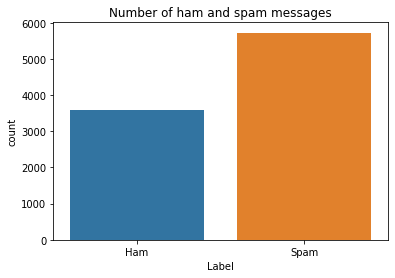

In [5]:
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [6]:
df.drop(['Category', 'Biller'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9324 entries, 0 to 9323
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     9324 non-null   object
 1   Messages  9324 non-null   object
dtypes: object(2)
memory usage: 145.8+ KB


In [0]:
num_of_categories = 3000
shuffled = df.reindex(np.random.permutation(df.index))
Spam = shuffled[shuffled['Label'] == 'Spam'][:num_of_categories]
Ham = shuffled[shuffled['Label'] == 'Ham'][:num_of_categories]
concated = pd.concat([Spam,Ham], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))

In [0]:
X = df.Messages
Y = df.Label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [0]:
max_words = 5000
max_len = 250
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [0]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [12]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 250)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 50)           250000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [13]:
 model.fit(sequences_matrix,Y_train,batch_size=325,epochs=2, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 6340 samples, validate on 1585 samples
Epoch 1/2
6340/6340 [==============================] - 36s 6ms/step - loss: 0.3650 - acc: 0.8880 - val_loss: 0.0455 - val_acc: 0.9994
Epoch 2/2
6340/6340 [==============================] - 35s 6ms/step - loss: 0.0168 - acc: 0.9992 - val_loss: 0.0034 - val_acc: 0.9994


In [0]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [15]:
accr = model.evaluate(test_sequences_matrix,Y_test)

1399/1399 [==============================] - 3s 2ms/step


In [16]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.5f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.003
  Accuracy: 0.99929


In [24]:
from keras.models import Sequential
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset_Categories.csv',encoding ='unicode_escape', usecols=['Messages', 'Category'])
s_num_of_categories = 250
s_shuffled = data.reindex(np.random.permutation(data.index))
Prepaid = s_shuffled[s_shuffled['Category'] == 'Prepaid'][:s_num_of_categories]
Electricity = s_shuffled[s_shuffled['Category'] == 'Electricity'][:s_num_of_categories]
DTH = s_shuffled[s_shuffled['Category'] == 'DTH'][:s_num_of_categories]
Postpaid = s_shuffled[s_shuffled['Category'] == 'Postpaid'][:s_num_of_categories]
#Extra = s_shuffled[s_shuffled['Category'] == 'Extra'][:s_num_of_categories]
s_concated = pd.concat([Prepaid,Electricity,DTH,Postpaid], ignore_index=True)
s_concated = s_concated.reindex(np.random.permutation(s_concated.index))
s_concated['LABEL'] = 0
s_concated.loc[s_concated['Category'] == 'Prepaid', 'LABEL'] = 0
s_concated.loc[s_concated['Category'] == 'Electricity', 'LABEL'] = 1
s_concated.loc[s_concated['Category'] == 'DTH', 'LABEL'] = 2
s_concated.loc[s_concated['Category'] == 'Postpaid', 'LABEL'] = 3
#s_concated.loc[s_concated['Category'] == 'Extra', 'LABEL'] = 4
labels = to_categorical(s_concated['LABEL'], num_classes=4)
if 'Category' in s_concated.keys():
    s_concated.drop(['Category'], axis=1)
'''
  [1. 0. 0. 0.] e
  [0. 1. 0. 0.] b
  [0. 0. 1. 0.] t
  [0. 0. 0. 1.] m
'''

s_n_most_common_words = 200
s_max_len = 70
tokenizer = Tokenizer(num_words=s_n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(s_concated['Messages'].values)
sequences = tokenizer.texts_to_sequences(s_concated['Messages'].values)
s_word_index = tokenizer.word_index
X = sequence.pad_sequences(sequences, maxlen=max_len)
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.20)
s_epochs = 35
s_emb_dim = 70
s_batch_size = 10
s_model = Sequential()
s_model.add(Embedding(s_n_most_common_words,s_emb_dim, input_length=X.shape[1]))
s_model.add(SpatialDropout1D(0.5))
s_model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.5))
s_model.add(Dense(4, activation='softmax'))
s_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = s_model.fit(X_train, y_train, epochs=s_epochs, batch_size=s_batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
accr = s_model.evaluate(X_test,y_test)

Train on 103 samples, validate on 26 samples
Epoch 1/35
103/103 [==============================] - 3s 32ms/step - loss: 1.3652 - acc: 0.4272 - val_loss: 1.3362 - val_acc: 0.5769
Epoch 2/35
103/103 [==============================] - 3s 27ms/step - loss: 1.3225 - acc: 0.5243 - val_loss: 1.2789 - val_acc: 0.5769
Epoch 3/35
103/103 [==============================] - 3s 26ms/step - loss: 1.2579 - acc: 0.5631 - val_loss: 1.2073 - val_acc: 0.5769
Epoch 4/35
103/103 [==============================] - 3s 26ms/step - loss: 1.1756 - acc: 0.5340 - val_loss: 1.0985 - val_acc: 0.5769
Epoch 5/35
103/103 [==============================] - 3s 25ms/step - loss: 1.1055 - acc: 0.5340 - val_loss: 0.9637 - val_acc: 0.5769
Epoch 6/35
103/103 [==============================] - 3s 26ms/step - loss: 1.0183 - acc: 0.5340 - val_loss: 0.8588 - val_acc: 0.6538
Epoch 7/35
103/103 [==============================] - 3s 26ms/step - loss: 0.9269 - acc: 0.6214 - val_loss: 0.7720 - val_acc: 0.6538
Epoch 8/35
103/103 [====

In [0]:
def mainfunc(txt):
   seq = tokenizer.texts_to_sequences(txt)
   padded = sequence.pad_sequences(seq, maxlen=max_len)
   pred = s_model.predict(padded)
   labels = ['Prepaid', 'Electricity', 'DTH','Postpaid']
   print(pred, labels[np.argmax(pred)])

In [26]:
txt =["Recharge your suspended Airtel DigitalTV ID 3005294022 with your rental and watch all your package channels. Recharge Online or from nearest recharge dealer."]
seq = tok.texts_to_sequences(txt)
padded = sequence.pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
print(pred)
if(pred < 0.5):
  print("Ham")
  mainfunc(txt)

else:
  print ("Spam")

[[0.20766842]]
Ham
[[0.03699675 0.02974504 0.9028018  0.03045639]] DTH
